# Determine validity (and pressure offset) of using Cahto Pk barometric pressure data when Sagehorn barometric pressure data is bad; offset between dry ck and ridge as well

In [2]:
# Import required libraries

import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = "Arial"
import pandas as pd
from pandas import Timedelta
import numpy as np
%matplotlib inline
import databaseQuery
from math import isnan



In [3]:

startDateTime = pd.to_datetime('2015-11-27 00:00:00')
stopDateTime = pd.to_datetime('2020-12-01 00:00:00')

# Import pressure data
## Import from mySQL database 
#Convert datetime stamps to strings for the sql query
dateStart = str(startDateTime.year) + '-' + str(startDateTime.month) + '-' + str(startDateTime.day)
dateStop =  str(stopDateTime.year) + '-' + str(stopDateTime.month) + '-' + str(stopDateTime.day)

#here we make use of external .py file with odmquery function (thanks Collin!) to get data from the database
#2958 = Barometric Pressure, WSSR, mBar
# 61	BP Cahto Peak
atmPSagehorn = databaseQuery.odmquery(dateStart, dateStop, '2958', True)

atmPCahto = databaseQuery.odmquery(dateStart, dateStop, '61', True)



In [4]:
atmPSagehorn.columns=['SagehornP']
atmPCahto.columns=['CahtoP']


atmP = atmPCahto.merge(atmPSagehorn,left_index=True, right_index=True,how='inner')
#not sure why but some dups in the pressure timeseries
# atmP = atmP[~atmP.index.duplicated(keep='first')]
atmP.head()

,Cahto,Sagehorn
LocalDateTime,,
2015-11-27 00:00:00,873.3873,936.0
2015-11-27 00:05:00,873.3062,936.0
2015-11-27 00:10:00,873.4685,936.0
2015-11-27 00:15:00,873.5496,936.0
2015-11-27 00:20:00,873.5496,936.0


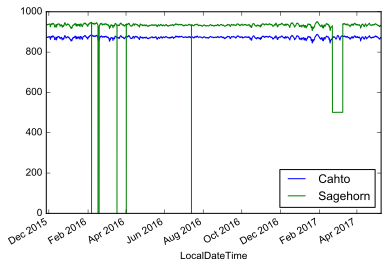

In [5]:
atmP.plot()


In [6]:
atmP['Sagehorn'][atmP['Sagehorn'] < 875] = np.nan


count    147644.000000
mean         61.492724
std           1.548705
min          57.129400
5%           58.470830
50%          61.912100
95%          63.458500
max          66.162100
Name: Dif, dtype: float64

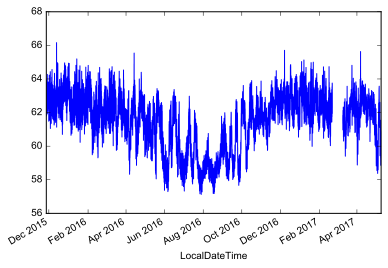

In [9]:
atmP['Dif']=atmP['Sagehorn']-atmP['Cahto']
atmP['Dif'].plot()
atmP['Dif'].describe(percentiles=[0.05,0.95])

In [22]:
dryP = pd.read_csv('Data/dry-atm-pressure 23apr2017 1035-8.csv',sep=',',  skiprows = 11)
dryP['datetime'] = pd.to_datetime(dryP['Date'] + ' ' + dryP['Time'])
dryP.drop(['Date'],inplace=True,  axis=1)
dryP.drop(['Time'],inplace=True,  axis=1)
dryP['datetime'] =  pd.to_datetime(dryP['datetime'], dayfirst=True)
dryP.set_index(['datetime'], drop=True, inplace=True)
dryP.drop(['ms'],inplace=True,  axis=1)
dryP.drop(['TEMPERATURE'],inplace=True,  axis=1)
dryP.columns=['dryP']
dryP['dryP']=dryP['dryP']/0.0101972 #m to mbar
dryP.head()

,dryP
datetime,
2017-03-09 19:00:00,949.417487
2017-03-09 19:15:00,949.417487
2017-03-09 19:30:00,949.427294
2017-03-09 19:45:00,949.623426
2017-03-09 20:00:00,949.437100


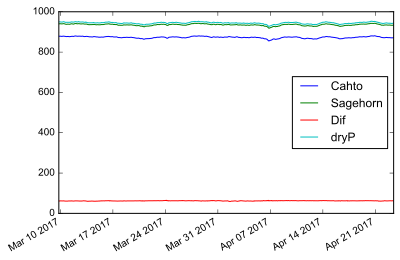

In [23]:
atmP = atmP.merge(dryP,left_index=True, right_index=True,how='inner')
atmP.plot()

count    4299.000000
mean        9.246153
std         0.402432
min         7.123031
25%         9.010977
50%         9.217198
75%         9.503371
max        10.921765
Name: difDry-Ridge, dtype: float64

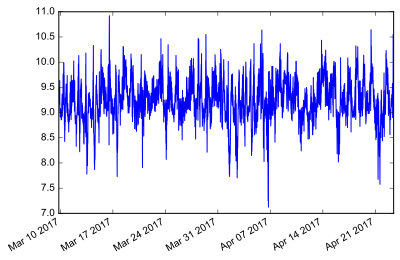

In [24]:
atmP['difDry-Ridge']=atmP['dryP']-atmP['Sagehorn']
atmP['difDry-Ridge'].plot()
atmP['difDry-Ridge'].describe()

In [31]:
group_df = atmP.groupby(atmP.index.date)
group_df = group_df.aggregate({pd.np.min})
group_df.index = group_df.index.to_datetime()
dailyMin = group_df.resample('15min',fill_method='ffill')
dailyMin.head()

C:\Users\wjh\Anaconda\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: fill_method is deprecated to .resample()
the new syntax is .resample(...).ffill()


,Cahto,Sagehorn,Dif,dryP,difDry-Ridge
,amin,amin,amin,amin,amin
2017-03-09 00:00:00,878.6018,940.1431,61.1364,949.417487,8.913826
2017-03-09 00:15:00,878.6018,940.1431,61.1364,949.417487,8.913826
2017-03-09 00:30:00,878.6018,940.1431,61.1364,949.417487,8.913826
2017-03-09 00:45:00,878.6018,940.1431,61.1364,949.417487,8.913826
2017-03-09 01:00:00,878.6018,940.1431,61.1364,949.417487,8.913826


In [34]:
daily=atmP.join(dailyMin)
daily['difDry-Ridge-dif'] = daily['difDry-Ridge']-daily['difDry-Ridge', 'amin']


In [35]:
daily.head()

,Cahto,Sagehorn,Dif,dryP,difDry-Ridge,"(Cahto, amin)","(Sagehorn, amin)","(Dif, amin)","(dryP, amin)","(difDry-Ridge, amin)",difDry-Ridge-dif
2017-03-09 19:00:00,878.7639,940.1431,61.3792,949.417487,9.274387,878.6018,940.1431,61.1364,949.417487,8.913826,0.360561
2017-03-09 19:15:00,878.6018,940.1431,61.5413,949.417487,9.274387,878.6018,940.1431,61.1364,949.417487,8.913826,0.360561
2017-03-09 19:30:00,878.6102,940.1431,61.5329,949.427294,9.284194,878.6018,940.1431,61.1364,949.417487,8.913826,0.370368
2017-03-09 19:45:00,878.9633,940.1431,61.1798,949.623426,9.480326,878.6018,940.1431,61.1364,949.417487,8.913826,0.566500
2017-03-09 20:00:00,878.6566,940.1431,61.4865,949.437100,9.294000,878.6018,940.1431,61.1364,949.417487,8.913826,0.380174


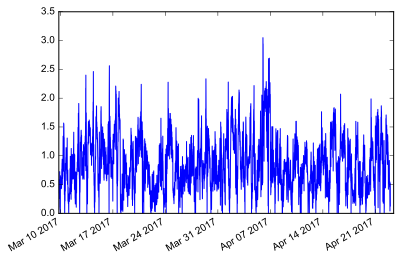

In [36]:
daily['difDry-Ridge-dif'].plot()

In [37]:
daily['time']=daily.index.time
daily['date']=daily.index.date

In [42]:
daily_avg = pd.pivot_table(daily, index=["time"], columns=["date"], values=["difDry-Ridge-dif"])
daily_avg.head()

difDry-Ridge-dif                                              \
date           2017-03-09 2017-03-10 2017-03-11 2017-03-12 2017-03-13   
time                                                                    
00:00:00              NaN   0.653961   0.290965   0.718936   1.071118   
00:15:00              NaN   0.575508   0.212512   0.611063   1.041698   
00:30:00              NaN   0.546088   0.428257   0.669903   1.041698   
00:45:00              NaN   0.634347   0.457677   0.689516   0.992665   
01:00:00              NaN   0.599361   0.336643   0.658950   1.052439   

                                                                   ...      \
date     2017-03-14 2017-03-15 2017-03-16 2017-03-17 2017-03-18    ...       
time                                                               ...       
00:00:00   1.171956   0.613566   0.882330   1.271089   0.098066    ...       
00:15:00   1.083697   0.525306   0.941170   1.114183   0.098066    ...       
00:30:00   1.015051   0.456660   1.039236   1.045537   0.029420    ...       
00:45:00   1.132730   0.397820   1.068656   0.927858   0.019613    ...       
01:00:00   1.109670   0.617347   0.857823   1.374751   0.166712    ...       

                                                                            \
date     2017-04-14 2017-04-15 2017-04-16 2017-04-17 2017-04-18 2017-04-19   
time                                                                         
00:00:00   0.856565   1.406983   0.911146   0.394579   0.270918   0.320890   
00:15:00   0.827145   1.279497   0.685594   0.443612   0.172852   0.262051   
00:30:00   0.836951   1.475630   0.754240   0.443612   0.221885   0.183598   
00:45:00   0.915404   1.583502   0.646367   0.522065   0.241498   0.193404   
01:00:00   0.775031   1.439850   0.784529   0.423999   0.267759   0.440872   

                                                      
date     2017-04-20 2017-04-21 2017-04-22 2017-04-23  
time                                                  
00:00:00   0.389191   1.518422   0.207965   0.127486  
00:15:00   0.438224   1.449776   0.433517        NaN  
00:30:00   0.389191   1.283063   0.345258        NaN  
00:45:00   0.369577   1.508615   0.511970        NaN  
01:00:00   0.320544   1.471038   0.304738        NaN  

[5 rows x 46 columns]

In [48]:
#now, average all days into one day
diurnal = daily_avg.mean(axis=1).to_frame()

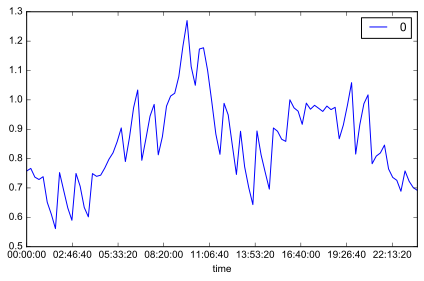

In [49]:
diurnal.plot()
plt.tight_layout()

some indication that the atmospheric pressure difference between dry creek and ridge is highest in day and smaller at night. 